# Matching Uncharged Templates to Charged Mock Data through Matched Filtering

Based on code provided at LIGO open science center and theory found in Maggiore's Gravitational Waves, volume 1

In [56]:
# Standard python numerical analysis imports:
import numpy as np
from numpy.fft import fft,ifft,fftfreq
from numpy.random import normal
from numpy import diff, pi, sin, sqrt, conj
from pynverse import inversefunc
from scipy import signal
from scipy.optimize import fsolve
from scipy.stats import linregress
from functools import reduce
from time import time,clock
import matplotlib.mlab as mlab
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
%matplotlib inline

#Fortran made functions (f2py)
#from fortfuncs import makeallparsfort, findsnrfort, getsnrgridfort, findrelationfort

## 0: Units

We'll in the following use $G= k_e = c = M_\odot = 1$, so that everything will be dimensionless, and we have the following conversion factors:

To time, multiply $ \frac{G M_\odot}{c^3}$.

To mass, multiply $ M_\odot$.

To length, multiply $ \frac{G M_\odot}{c^2} $.

In [57]:
#SWITCH
FORT = False
#NB Fortran version not finished and discontinued

G = 6.67408e-11
c = 2.99792458e8
Ms = 1.989e30
#Conversion factors
Time = G*Ms/c**3.
Length = G*Ms/c**2.

#More stuff (global)
#About same tau0 as for GW150914 (at LOSC)
tau0 = 16./Time #Convert from seconds to dimensionless units
N = 1. #N is equivalent to sqrt(S0) for the spectral function
cutoff = 0.1
fmin = 20.*Time
fmax = 2e3*Time 
f0 = 215.*Time 
fs = 4096.*Time # From LOSC
du = (1./fs)/(tau0)
#From LOSC:
NFFT = int(4*fs/Time)
psd_window = np.blackman(NFFT)
NOVL = int(NFFT/2)

## 1: Parameters/Symbols

tau0 $\sim\tau_0$ is the initial time to coalescence. We're not interesting in varying this, so we'll assume that it can be fixed and do the analysis below for a fixed value.

Mc $\sim\mathcal{M}^*_c$ is the generalised chirp mass.

muq $\sim\mu (\Delta \sigma )^2$ is the reduced mass times the difference squared of charge to mass ratio of the 2 components.

N $\sim$ max(noise)/max(h) in the first half of inspiral in mock data

And finally h $\sim h$, is the waveform without the polarisation tensor (which is contracted with the detector tensor and just introduces a rescaling with variables that we won't vary (angles..)).

# 2: Template/Mock Data Production

1.0920000000000005


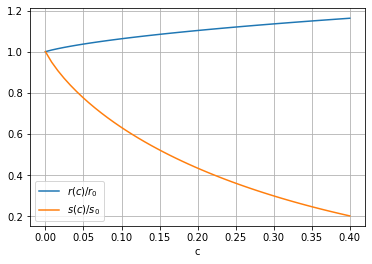

In [58]:
#Noise
#f>fs, from 0601072
SnS0 = lambda x: x**(-4.14) - 5.*x**(-2.) + \
    111.*(1.-x**2. + 0.5*x**4.)/(1.+0.5*x**2.)


#Parameter vector
getpar = lambda tau0,Mc,muq,phase: np.array([tau0,Mc,muq,phase])

#Some quantities // Results from analytic work
Aw = lambda Mc: 5./( 96.*Mc**(5./3.) )
w0 = lambda tau0,Mc: ( 3.*Aw(Mc)/(8.*tau0) )**(3./8.) #Only to first order
epsw = lambda Mc, muq: 5.*muq/(48.*Mc**(5./3.))
C = lambda tau0, Mc, muq: epsw(Mc,muq) * (3./14.) * w0(tau0,Mc)**(-2./3.)
w_func = lambda u,pars: w0(pars[0],pars[1]) * u**(-3./8.) \
    * (1. - (3./10.) * epsw(pars[1],pars[2])*w0(pars[0],pars[1])**(-2./3.) * u**(1./4.) )

#Phase
Phi = lambda u,par: par[3] + (16./5.)*par[0]*w0(par[0],par[1]) \
    * ( 1. - u**(5./8.) - C(par[0],par[1],par[2])*( 1. - u**(7./8.) ) ) 

#Normalised amplitude, because we don't care about distance or inclination
F = lambda u,par: w0(par[0],par[1])**(2./3.)*u**(-1./4.) \
    - epsw(par[1],par[2])/5.

#The waveform
h = lambda u,par: F(u,par)*np.sin(Phi(u,par))
noh = lambda u,par: u*0.

#Analytically found bias from least squares

rconst = lambda c: ( 8.*(1.-c**(15./8.))*(5./13. - c + 8.*c**(13./8.)/13.)/(15.*(1.-c)) \
                  - 2./15. + 8.*c**(15./8.)/15. - 2.*c**(5./2.)/5.) / \
                ( 25./117. - c + 16.*c**(13./8.)/13. - 4.*c**(9./4.)/9. \
                 - (5./13. - c + 8.*c**(13./8.)/13.)**2./(1.-c) )
sconst = lambda c: 1.-(rconst(c)*(5./13. - c + 8.*c**(13./8.)/13.) + 8.*(1.-c**(15./8.))/15.) \
                / (1.-c)

analytbias = lambda pars,c: 1. + 8.*rconst(c)*C(pars[0],pars[1],pars[2])/5.

analytphas = lambda pars,c: - 16.*pars[0]*w0(pars[0],pars[1]) \
    * sconst(c)*C(pars[0],pars[1],pars[2])/5.

cs = np.linspace(0.,0.4)
plt.plot(cs,rconst(cs)/rconst(0.),label='$r(c)/r_0$')
plt.plot(cs,sconst(cs)/sconst(0.),label='$s(c)/s_0$')
plt.xlabel('c')
plt.legend()
plt.grid()
print(rconst(0))


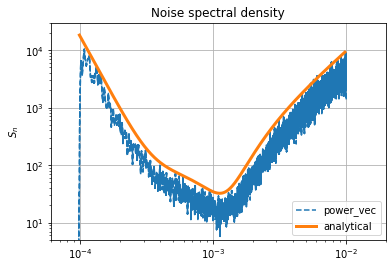

In [59]:
def makenoisevec(Npoints):
    dt = 1./fs
    N = int(Npoints/2.)
    x = np.linspace(fmin/f0,fmax/f0,N)
    df = f0*(x[1]-x[0])
    nullen = int(fmin/df)
    NN = N*2 + 2*nullen + 1
    z1 = np.zeros(N)
    z2 = np.zeros(N)
    for i in range(N):
        z1[i] = normal(0,1)
        z2[i] = normal(0,1)
        
    nsqr = N*dt*SnS0(x)/2.
    noise = np.zeros(N,np.complex)

    for i in range(N):
        noise[i] = (z1[i]+1.j*z2[i])*sqrt(nsqr[i])/sqrt(2)
        
    #NB! Rearrange negative and positive frequencies into convention
    #So that inverse Fourier is real within machine prec.
    f = np.linspace(-fmax,fmax,NN)
    noises = np.zeros(len(f),np.complex)
    noises[nullen+1:nullen+1+N] = noise
    noises[nullen+N+1:nullen+2*N+1] = conj(noise[::-1])
    return ifft(noises)[:Npoints].real*fs


#Find the power vector
us = np.arange(1.,0.,-du)
noisevec = makenoisevec(2*len(us))
sfreq = fftfreq(len(us)*2)*fs
data_psd, freqs = mlab.psd(noisevec, Fs = fs, NFFT = NFFT , window=psd_window, noverlap=NOVL)
power_vec = np.interp(np.abs(sfreq), freqs, data_psd)
df = abs(sfreq[1]-sfreq[0])*fs

#plt.loglog(freqs,data_psd)
plt.loglog(abs(sfreq)[:],power_vec[:],'--',label='power_vec')
x = np.linspace(fmin/f0,fmax/f0,1000)
plt.loglog(x*f0,SnS0(x),lw=3,label='analytical')
plt.xlim(6e-5,2e-2)
plt.ylim(5,3e4)
plt.grid()
plt.ylabel('$S_n$')
plt.title('Noise spectral density')
plt.legend()

def mock(h,du,N,truepars,cutoff):   
    us = np.arange(1.,0.,-du)
    ht = np.zeros(2*len(us))
    ind = int(len(us)*(1-cutoff))-1
    norm = 1.
    ht[:ind] = h(us[:ind],truepars)
    if (h!=noh):
        #hf = fft(ht)/fs
        #norm = np.sqrt(abs(2.*df*(hf*conj(hf)/power_vec).sum()))
        norm = F(0.05/(Time*truepars[0]),truepars)
    ht = ht/norm
    if (N>0.):
        noisevec = makenoisevec(len(ht))
        ht += noisevec*N
    return ht

## Test

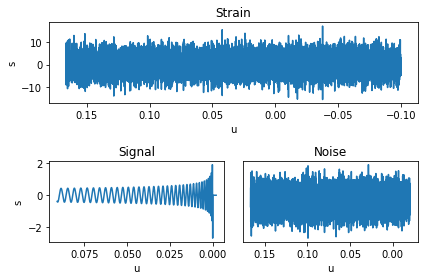

In [60]:
cutstore = cutoff
cutoff=0.
truepars = getpar(tau0,30.,0.,0.)
s = mock(h,du,0.,truepars,cutoff)
us = np.linspace(1.,0.,len(s)//2)
us2 = np.linspace(1,-1,2*len(us))

start = int(len(us)/1.1)
stop = int(len(us2)*0.501)

fig = plt.figure()

ax = fig.add_subplot(223)
plt.plot(us2[start:stop],s[start:stop])
#plt.axvline(x=cutoff,color='r',alpha=0.8)
ax.invert_xaxis()
ax.set_title('Signal')
plt.xlabel('u')
plt.ylabel('s')

start = int(len(us)/1.2)
stop = len(us2) - int(len(us)*0.9)


ax2 = fig.add_subplot(211)
s = mock(h,du,N,truepars,cutoff)
plt.plot(us2[start:stop],s[start:stop])
ax2.invert_xaxis()
ax2.set_title('Strain')
plt.xlabel('u')
plt.ylabel('s')

start = int(len(us)/1.2)
stop = int(len(us2)*0.51)

pars = np.array([-tau0,30.,0.,0.])
s = mock(noh,du,N,pars,cutoff)
ax3 = fig.add_subplot(224)
plt.plot(us2[start:stop],s[start:stop])
ax3.set_title('Noise')
ax3.invert_xaxis()
plt.xlabel('u')
plt.ylabel('s')
ax3.yaxis.set_visible(False)

fig.tight_layout()
plt.savefig('waveformAndNoise.eps',bbox_inches='tight')
cutoff = cutstore

# 3: Finding SNR

In [6]:
#Following function taken and adapted from LOSC
def findSNRPYT(st,ht,cutoff):
    dwindow = 1 
    
    sf = fft(st*dwindow)/fs
    hf = fft(ht*dwindow)/fs    
        
    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    SNR = (2.*sf * hf.conjugate()/power_vec).sum()*df
    # -- Normalize the matched filter output: 
    sigmasq = 2.*(hf * hf.conjugate()/power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    #Return a vector (just because of the code at first being written around getting a time-series out)
    return (( SNR/sigma )).real * np.ones(len(sf)) #This is the SNR




In [7]:
def findSNR(st,ht,cutoff):
    #NB switch
    #if (FORT):
    #    return findsnrfort(ifft(sf).real,ifft(hf).real,len(sf),cutoff)
    #else:
    return findSNRPYT(st,ht,cutoff)

## Test

In [8]:
truepars = np.array([tau0,30.,0.2,0.])
st = mock(h,du,N,truepars,cutoff)
us = np.linspace(1,-1,len(st))
template = mock(h,du,0.,truepars,cutoff)
SNR = findSNR(st,template,cutoff)
SNRmax = SNR.max()
print("SNR (not normalised):\t",SNRmax)



##Below for when using time-series
#plt.plot(us,SNR)
#plt.ylabel('SNR')
#plt.xlabel('u')


#disp = 0.03
#plt.figure()
#plt.plot(us[int(len(us)*(0.5-disp)):int(len(us)*(0.5+disp))],SNR[int(len(us)*(0.5-disp)):int(len(us)*(0.5+disp))])
#plt.ylabel('SNR')
#plt.xlabel('u')

SNR (not normalised):	 649523.4275079005


# 4: Matched Filtering

In [9]:
#Make template grid
def makeallparsPYT(tau0,chirps,muqs,phas):
    allpars = np.zeros(len(chirps)*len(muqs)*len(phas)*4).reshape(len(chirps),len(muqs),len(phas),4)
    for i in range(len(chirps)):
        for j in range(len(muqs)):
            for k in range(len(phas)):
                allpars[i,j,k,:] = np.array([tau0,chirps[i],muqs[j],phas[k]])
    return allpars

In [10]:
def makeallpars(tau0,chirps,muqs,phas):
    return makeallparsPYT(tau0,chirps,muqs,phas)
    #return makeallparsfort(tau0,chirps,muqs,phas,len(chirps),len(muqs),len(phas))

## Just comparing SNRs

In [11]:
def getSNRgridPYT(allpars,truepars,du,N,cutoff):
    st = mock(h,du,N,truepars,cutoff)
    grid = np.zeros(reduce(lambda x,y: x*y,allpars[:,:,:,0].shape)).reshape(allpars[:,:,:,0].shape)
    for i in range(allpars.shape[0]):
        #print(i/allpars.shape[0],end='\t')
        for k in range(allpars.shape[2]):
            for j in range(allpars.shape[1]):
                temp = findSNR(st,mock(h,du,0.,allpars[i,j,k],cutoff),cutoff)
                grid[i,j,k] = temp.max()
    return grid

def findBestSNR(SNRgrid,allpars):
    maxSNR = SNRgrid.max()
    maxSNRpars = allpars[np.where(SNRgrid==maxSNR)][0]
    return maxSNR,maxSNRpars

In [12]:
def getSNRgrid(allpars,truepars,du,N,cutoff):
    #length = int(2./du + 0.5)
    #dim = allpars.shape
    #NB switch
    #if (FORT):
    #    return getsnrgridfort(allpars,dim[0],dim[1],dim[2], truepars,length,N,cutoff)
    #else:
    return getSNRgridPYT(allpars,truepars,du,N,cutoff)

## Test

In [16]:
#%%script false --no-raise-error

truepars = getpar(tau0,30.,0.2,0.)

chirps = np.arange(29.9,31.8,0.1)
muqs = np.array([0.,]) #No charged templates
phas = np.arange(0.,-pi,-pi/32.)
allpars = makeallpars(tau0,chirps,muqs,phas)

print("Finding SNRs...")
start = time()
SNRgrid = getSNRgrid(allpars,truepars,du,N,cutoff)
maxSNR,maxSNRpars = findBestSNR(SNRgrid,allpars)
end = time()

savedtrue = 1.*truepars #Shallow copy
savedfalse = 1.*maxSNRpars


print("Max SNR found:\t",maxSNR,"\nFor parameters (tau0,Mc,muq,phi0):\t",\
      maxSNRpars,"\nTrue parameters:\t\t\t",truepars, \
      "\nTotal time (s):\t",end-start)

Finding SNRs...
Max SNR found:	 649358.7941498437 
For parameters (tau0,Mc,muq,phi0):	 [ 3.24755040e+06  3.04000000e+01  0.00000000e+00 -1.96349541e-01] 
True parameters:			 [3.2475504e+06 3.0000000e+01 2.0000000e-01 0.0000000e+00] 
Total time (s):	 18.0836398601532


And with that we have successfully demonstrated a large mass bias (this is in the generalised chirp mass though..). The above test-code can also be verified to give back the correct parameters when those are covered by the matched filtering search.

Now we turn to look at the relationship between mass bias and $\mu (\Delta \sigma)^2>0$:

# 5: Chirp mass/charge relationship

In [13]:
"""serial
def findRelation(dMc,dmuq,du,N,runs,cutoff):
    #Using truepars defined above
    phas = np.arange(0,-2.*pi,-pi/32.)
    chirps = np.arange(29.9,31.8,dMc)
    muqs = np.arange(0.,.1,1.) #Not contained in matching space
    allpars = makeallpars(truepars[0],chirps,muqs,phas)
    truqs = np.arange(0.,maxmuq,dmuq)
    maxSNRs = np.zeros(len(truqs))
    maxPars = np.zeros(len(truqs)*4).reshape(len(truqs),4)
    trueSNRs = np.zeros(len(truqs))
    for i in range(len(truqs)):
        print("\n muqs:\t",round(float(i)/len(truqs),2),end=':\t')
        truepars[2] = truqs[i]
        for j in range(runs):
            #print(round(float(j),1)/runs,end='\t')
            SNRgrid = getSNRgrid(allpars,truepars,du,N,cutoff)
            temp1,temp2 = findBestSNR(SNRgrid,allpars)
            trueSNRs[i] += findSNR(mock(h,du,N,truepars,cutoff),mock(h,du,0.,truepars,cutoff),cutoff).max()
            maxSNRs[i] += temp1
            maxPars[i] += temp2
    return maxSNRs/trueSNRs, maxPars/runs, truqs
"""
#parallel

def findSNRpar(st,ht,cutoff,muq):
    return [findSNR(st,ht,cutoff),muq]
def getSNRgridpar(allpars,truepars,du,N,cutoff):
    return [getSNRgrid(allpars,truepars,du,N,cutoff),truepars[2]]

def findRelation(dMc,dmuq,du,N,runs,cutoff):
    #Using truepars defined above
    phas = np.arange(0,-pi/5.,-pi/256.)
    chirps = np.arange(29.9,31.8,dMc)
    muqs = np.arange(0.,.1,1.) #Not contained in matching space
    allpars = makeallpars(truepars[0],chirps,muqs,phas)
    truqs = np.arange(0.,maxmuq+dmuq,dmuq)
    maxSNRs = np.zeros(len(truqs))
    maxPars = np.zeros(len(truqs)*4).reshape(len(truqs),4)
    trueSNRs = np.zeros(len(truqs))
    grids = []
    trueres = []
    gridsob = []
    trueresob = []
    truqgrid = np.zeros(len(truqs))
    truqtrur = np.zeros(len(truqs))
    pool = mp.Pool(os.cpu_count())
    start = time()
    for i in range(len(truqs)):
        print("\n muqs:\t",round(float(i)/len(truqs),2),end=':\t') #Doesn't work with async
        truepars[2] = truqs[i] 
        #print(round(float(j),1)/runs,end='\t')
        gridsob.append((pool.starmap_async(getSNRgridpar,[[allpars,truepars,du,N,cutoff],]*runs)))
        trueresob.append(pool.starmap_async(findSNRpar,[[mock(h,du,N,truepars,cutoff),mock(h,du,0.,truepars,cutoff),cutoff,truepars[2]],]*runs))
        #print('EST Time:\t',(time()-start)*(len(truqs)-i-1)/(i+1)) #Doesn't work with async
    pool.close()
    pool.join
    for i in range(len(truqs)):
        grids.append(gridsob[i].get())
        trueres.append(trueresob[i].get())
        truqgrid[i] = grids[i][0][1]
        truqtrur[i] = trueres[i][0][1]
        for j in range(runs):
            trueSNRs[i] += max(trueres[i][j][0])
            temp1,temp2 = findBestSNR(grids[i][j][0],allpars)
            maxSNRs[i] += temp1
            maxPars[i] += temp2
    tempgrid = np.arange(len(truqgrid),dtype=np.int)
    temptru = np.arange(len(truqtrur),dtype=np.int)
    #NB there seems to be a bug appearing for large runs or len(truqs)
    a = list(zip(truqgrid,tempgrid))
    a.sort()
    b = list(zip(truqtrur,temptru))
    b.sort()
    maxSNRs = maxSNRs[np.array(a,dtype=np.int)[:,1]]
    maxPars = maxPars[np.array(a,dtype=np.int)[:,1],:]
    trueSNRs = trueSNRs[np.array(b,dtype=np.int)[:,1]]
    
    return maxSNRs/trueSNRs, maxPars/runs, truqs

In [15]:
"""
def findRelationFORT(dMc,dmuq,du,N,var,runs,cutoff):
    #NB something wrong don't use, and not much time to be gained anyway
    nmc = int((31.5-29.8)/dMc + 0.5)
    nmuq = int((0.6-0.)/dmuq + 0.5)
    nu = int(2./du + 0.5)
    return findrelationfort(nmc,nmuq,nu,N,var,runs,cutoff)
"""

"\ndef findRelationFORT(dMc,dmuq,du,N,var,runs,cutoff):\n    #NB something wrong don't use, and not much time to be gained anyway\n    nmc = int((31.5-29.8)/dMc + 0.5)\n    nmuq = int((0.6-0.)/dmuq + 0.5)\n    nu = int(2./du + 0.5)\n    return findrelationfort(nmc,nmuq,nu,N,var,runs,cutoff)\n"

## Test

In [16]:
runs = 20 #times 2
extraruns = 9 #walkaround of weirdness at runs>>20
maxmuq = 0.6
start = time()
maxSNRs, maxPars, truqs = findRelation(0.01,0.1,du,N,runs,cutoff)  #20 runs, 0.02, 0.1
for i in range(extraruns):
    maxSNRs2, maxPars2, truqs = findRelation(0.02,0.1,du,N,runs,cutoff)
    maxSNRs += maxSNRs2
    maxPars+= maxPars2
maxSNRs = maxSNRs/(1.+extraruns)
maxPars = maxPars/(1.+extraruns)
end = time()
print("Pyt time (min):\t",round((end-start)/60.,2))
#start = time()
#maxSNRs2, maxPars2, truqs = findRelationFORT(0.1,0.1,du,N,runs,cutoff)
#end = time()
#print("Fort time (s):\t",round((end-start),2))


 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muqs:	 0.57:	
 muqs:	 0.71:	
 muqs:	 0.86:	
 muqs:	 0.0:	
 muqs:	 0.14:	
 muqs:	 0.29:	
 muqs:	 0.43:	
 muq

Using cutoff for u<0.1, putting ht=st=0
Now with tau_0 = 15.999999999999998 s
[[ 3.24755040e+06  3.00000000e+01  0.00000000e+00  0.00000000e+00]
 [ 3.24755040e+06  3.02130000e+01  0.00000000e+00 -6.01320469e-02]
 [ 3.24755040e+06  3.04200000e+01  0.00000000e+00 -1.59534002e-01]
 [ 3.24755040e+06  3.06400000e+01  0.00000000e+00 -2.07394203e-01]
 [ 3.24755040e+06  3.08600000e+01  0.00000000e+00 -2.66299065e-01]
 [ 3.24755040e+06  3.10800000e+01  0.00000000e+00 -3.39930143e-01]
 [ 3.24755040e+06  3.13000000e+01  0.00000000e+00 -4.25833067e-01]]


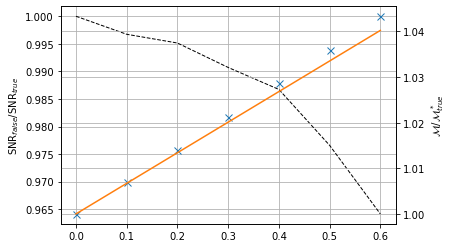

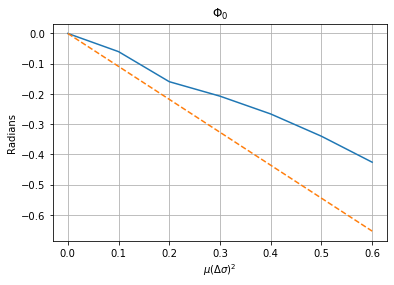

In [17]:
print("Using cutoff for u<",cutoff,", putting ht=st=0",sep='')
print("Now with tau_0 =",tau0*Time,"s")

maxchirp = np.zeros(len(maxPars))
maxphas = np.zeros(len(maxPars))
for i in range(len(maxSNRs)):
    maxchirp[i] = maxPars[i][1]
    maxphas[i] = maxPars[i][3]

fig,ax1 = plt.subplots()
    
plt.plot(truqs,maxSNRs,'--k',lw=1.)
#plt.plot(truqs,maxSNRs2/maxSNRs[0],lw=2., label='2')
#plt.legend()
#plt.grid()
plt.ylabel(r'SNR$_{false}/$SNR$_{true}$')
#plt.xlabel(r'$\mu(\Delta\sigma)^2$')
#plt.legend(loc='best')
plt.grid()

ax2 = ax1.twinx()

plt.plot(truqs,maxchirp/truepars[1],'x',ms=7.,label='Matched Filtering')
#plt.plot(truqs,maxPars2[:,1]/30.,lw=2.,label='Matched Filtering2')
#a,b,c,d,e = linregress(truqs,maxPars[:,1]/truepars[1])
#plt.plot(truqs,b+a*truqs)
plt.grid()

plt.ylabel(r'$\mathcal{M}/\mathcal{M}^*_{true}$')
plt.xlabel(r'$\mu (\Delta\sigma)^2/M_\odot$')
plt.plot(truqs,analytbias([tau0,truepars[1],truqs,1.],cutoff),lw=1.5,label='Least square for phase')
#plt.legend(loc='best')
#plt.title('Averaged over '+ str(runs) + " runs.")
#plt.grid()
#plt.savefig('chirpvscharge.eps',bbox_inches='tight')
#plt.figure()

plt.savefig('SNRchange.eps',bbox_inches='tight')

plt.figure()
plt.title(r'$\Phi_0$')
plt.plot(truqs,maxphas, label='Matched Filtering')
plt.plot(truqs,((analytphas(np.array([truepars[0],truepars[1],truqs,0.]),cutoff))), '--', label='Least square for phase')
plt.ylabel('Radians')
plt.xlabel(r'$\mu (\Delta \sigma)^2$')
plt.grid()
#plt.legend(loc='best')

Where we explain jumps in SNR by the discrete grids randomness (several realisations might smooth it out).

We note that the chirp mass ratio isn't very significant, considering $\sigma=1$ is a maximally charged body in these units.

Our smallness quantity is

$$
\epsilon_\omega \omega^{-2/3} = \frac{5\mu(\Delta\sigma)^2}{12 \mathcal{M}_*^{5/4}}\left(\frac{2\tau}{15}\right)^{1/4},
$$

In [18]:
print("Smallness quantity at greatest for current parameters:\t",epsw(truepars[1],maxmuq)*w0(truepars[0],truepars[1])**(-2./3.))

Smallness quantity at greatest for current parameters:	 0.10108458076305407


which for our example and choosing $m_1=m_2$ gives $\sim (\Delta\sigma)^2/5$ at $\tau_0=16$s, which should be small for any charges. Our approximation is better for small mass ratios or late time mergers (paradoxically with the early inspiral assumption).

However, for the actual chirp mass ratio, we have:
$$
\mathcal{M}^* = (1-\sigma_1\sigma_2)^{2/5}\mathcal{M},
$$
which would still cause significant deviations from the actual chirp mass in measurements even if the above effect is small. If we approximate the above as negligible in comparison (for both charged bodies), we have:
$$
\frac{\mathcal{M}_{\text{observed}} }{\mathcal{M}_{\text{true}}} \simeq 1 -\sigma_1\sigma_2,
$$
which would cause a negative mass bias unless the charges are of opposite sign.

We also see a sharp decrease in SNR for inclusion of charge, and may therefore have these events go undetected at LIGO/VIRGO.

## 6: Cutoff Dependency of SNR & $\mathcal{M}$ (Now comparing charged/uncharged)

In [14]:
def findRelationCutoff(dMc, muq, cutoffs, du, N, runs):
    #Choosing here a true chirp at 30 solar masses
    phas = np.arange(0.,-pi/5.,-pi/32.)
    truepars = (tau0,30.,muq,0.)
    chirps = np.arange(30.1,30.4,dMc)
    allpars = makeallpars(truepars[0],chirps,np.array([0,]),phas)

    maxSNRs = np.zeros(len(cutoffs))
    maxChirps = np.zeros(len(cutoffs))
    
    for i in range(len(cutoffs)):
        print("\n cutoffs:\t",round(float(i)/len(cutoffs),2),end=':\t')
        for j in range(runs):
            SNRgrid = getSNRgrid(allpars,truepars,du,N,cutoffs[i])
            temp1,temp2 = findBestSNR(SNRgrid,allpars)
            maxSNRs[i] += temp1
            maxChirps[i] += temp2[1]
    return maxChirps/runs

In [83]:
#Chirp dependence
start = time()
cutoffs2 = np.linspace(0.,0.2,20)
runs2 = 4
dchirp = 0.01
maxChirps = findRelationCutoff(dchirp,0.6,cutoffs2,du,N,runs2)


 cutoffs:	 0.0:	
 cutoffs:	 0.05:	
 cutoffs:	 0.1:	
 cutoffs:	 0.15:	
 cutoffs:	 0.2:	
 cutoffs:	 0.25:	
 cutoffs:	 0.3:	
 cutoffs:	 0.35:	
 cutoffs:	 0.4:	
 cutoffs:	 0.45:	
 cutoffs:	 0.5:	
 cutoffs:	 0.55:	
 cutoffs:	 0.6:	
 cutoffs:	 0.65:	
 cutoffs:	 0.7:	
 cutoffs:	 0.75:	
 cutoffs:	 0.8:	
 cutoffs:	 0.85:	
 cutoffs:	 0.9:	
 cutoffs:	 0.95:	Time (sec):	 6241.41


In [92]:
#SNR dependence
truepars = 1.*savedtrue
wrongpars = 1.*savedfalse

cutoffs = np.linspace(0.,0.4,20)
cutSNRs = np.zeros(len(cutoffs))
runs = 10
for i in range(len(cutoffs)):
    temp = 0.
    temp2 = 0.
    st = mock(h,du,N,truepars,cutoffs[i])
    ht = mock(h,du,0.,wrongpars,cutoffs[i])
    for j in range(runs):
        temp += findSNR(st,ht,cutoffs[i])
    cutSNRs[i] = temp.max()/runs
end = time()
print("Time (sec):\t",round((end-start),2))


Time (sec):	 6738.49


Lower figure, muq = 0.6


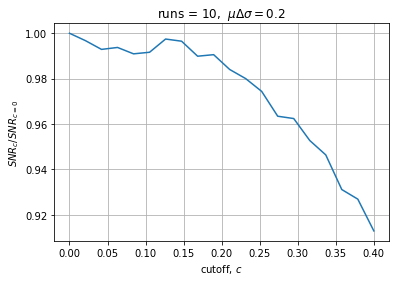

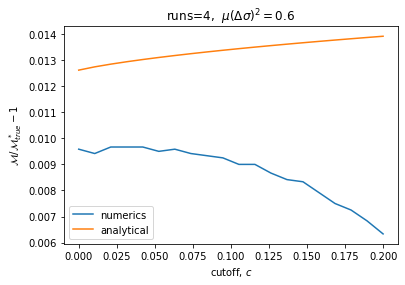

In [93]:
plt.plot(cutoffs,cutSNRs/cutSNRs[0])
plt.grid()
plt.ylabel(r'$SNR_c/SNR_{c=0}$')
plt.xlabel(r'cutoff, $c$')
plt.title('runs = ' +str(runs) + r',  $\mu\Delta \sigma =$'+str(truepars[2]))
plt.savefig('cutoff.png',bbox_inches='tight')
plt.figure()
plt.plot(cutoffs2,maxChirps/truepars[1] - 1,label='numerics')
plt.plot(cutoffs2,8.*C(truepars[0],truepars[1],truepars[2])*rconst(cutoffs2)/5.,label='analytical')
plt.xlabel(r'cutoff, $c$')
plt.ylabel(r'$\mathcal{M}/\mathcal{M}^*_{true}-1$')
plt.title('runs='+str(runs2)+r',  $\mu(\Delta\sigma)^2=0.6$')
plt.legend(loc='best')
plt.savefig('chirpvscutoffswave2.png',bbox_inches='tight')
#print(cutoffs2.shape,maxChirps.shape)
print("Lower figure, muq = 0.6")

We see that although the least square consideration gives a cutoff-dependence on mass estimation, it is different in the matched filtering. For smaller $\mu(\Delta\sigma)^2$ it needs small dchirp to at all resolve.

## 7: Initial Time Dependecy of Least Square and Templates

In [22]:
start = time()

tau0s = np.linspace(10./Time,300./Time,100)
diffs = np.zeros(len(tau0s))

for i in range(len(tau0s)):
    print(round(i/len(tau0s),2),end='\t')
    truepars = (tau0s[i],savedtrue[1],savedtrue[2],savedtrue[3])
    wrongpars = (tau0s[i],savedfalse[1],savedfalse[2],savedfalse[3])
    st = mock(h,du,0.,truepars,cutoff)
    ht = mock(h,du,0.,wrongpars,cutoff)
    cutind = int((1-cutoff)*len(st)/2)
    diffs[i] = np.sum((st-ht)[:cutind]**2.)*du
end = time()

print("Time (min):\t",round((end-start)/60.,2))

0.0	0.01	0.02	0.03	0.04	0.05	0.06	0.07	0.08	0.09	0.1	0.11	0.12	0.13	0.14	0.15	0.16	0.17	0.18	0.19	0.2	0.21	0.22	0.23	0.24	0.25	0.26	0.27	0.28	0.29	0.3	0.31	0.32	0.33	0.34	0.35	0.36	0.37	0.38	0.39	0.4	0.41	0.42	0.43	0.44	0.45	0.46	0.47	0.48	0.49	0.5	0.51	0.52	0.53	0.54	0.55	0.56	0.57	0.58	0.59	0.6	0.61	0.62	0.63	0.64	0.65	0.66	0.67	0.68	0.69	0.7	0.71	0.72	0.73	0.74	0.75	0.76	0.77	0.78	0.79	0.8	0.81	0.82	0.83	0.84	0.85	0.86	0.87	0.88	0.89	0.9	0.91	0.92	0.93	0.94	0.95	0.96	0.97	0.98	0.99	Time (min):	 0.06


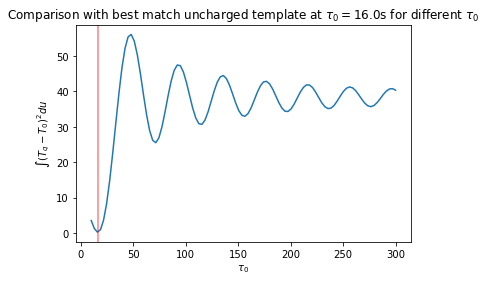

In [23]:
norm = diffs[np.where(tau0s*Time>16.)[0][0]]
plt.plot(tau0s*Time,diffs/norm)
plt.axvline(x=savedtrue[0]*Time,alpha=0.5,color='r')
plt.xlabel(r'$\tau_0$')
plt.ylabel(r'$\int (T_q - T_0)^2 du$')
plt.title(r'Comparison with best match uncharged template at $\tau_0=$' + str(round(savedtrue[0]*Time,1)) + r's for different $\tau_0$')
plt.savefig('tau0var.png',bbox_inches='tight')

In [77]:
cutoff = 0.0
chirps = np.arange(29.8,33.,0.1)
muqs = np.array([0.,]) #No charged templates
phas = np.arange(0.,-pi/2.,-pi/32.)
us = np.arange(1.,-1,-du)
def tau0change(tau0,tau02,pars):
    truepars = pars*1.
    truepars2 = np.array([tau02,pars[1],pars[2],pars[3]])
    truepars2[3] = -Phi(tau0/tau02,truepars2)
    trueh = mock(h,du,0.,truepars,cutoff)
    trueh2 = mock(h,du,0.,truepars2,cutoff)
    allpars = makeallpars(truepars[0],chirps,muqs,phas)
    allpars2 = makeallpars(truepars2[0],chirps,muqs,phas)
    SNRgrid = getSNRgrid(allpars,truepars,du,0.,cutoff)
    SNRgrid2 = getSNRgrid(allpars2,truepars2,du,0.,cutoff)
    temp, bestpars = findBestSNR(SNRgrid,allpars)
    temp, bestpars2 = findBestSNR(SNRgrid2,allpars2)
    falseh1 = mock(h,du,0.,bestpars,cutoff)
    falseh2 = mock(h,du,0.,bestpars2,cutoff)
    return trueh,trueh2,falseh1,falseh2, bestpars, bestpars2, truepars, truepars2

timestart = time()
pars = np.array([0.,30.,0.2,0.])
tau0 = 10./Time
pars[0] = tau0
tau02 = 0.6/Time
trueh1, trueh2, falseh1, falseh2, bestpars1, bestpars2, \
    truepars1, truepars2 = tau0change(tau0,tau02,pars)
end = time()
print("Time (s):\t",round((end-timestart)),2)

Time (s):	 29 2


/home/oyvind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in power
/home/oyvind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


Should all have same amplitude at normalisation...


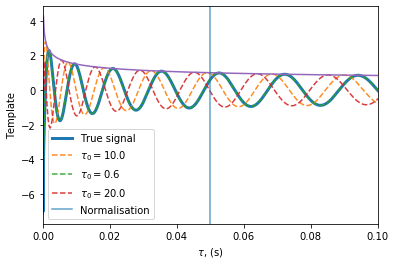

In [82]:
def plottau0change(tau0,tau02,pars):
    trueh1, trueh2, falseh1, falseh2, bestpars1, \
        bestpars2, truepars1, truepars2 = tau0change(tau0,tau02,pars)
    plt.plot(us*bestpars2[0]*Time,falseh2,\
             '--',alpha=0.9,label=r'$\tau_0=$'+str(round(bestpars2[0]*Time,2)))

plt.figure()

plt.plot(us*tau02*Time,trueh2,lw=3.,label='True signal')
plt.plot(us*bestpars1[0]*Time,falseh1,'--',alpha=0.9,label=r'$\tau_0=$'+str(round(bestpars1[0]*Time,2)))
plt.plot(us*bestpars2[0]*Time,falseh2,'--',alpha=0.9,label=r'$\tau_0=$'+str(round(bestpars2[0]*Time,2)))
plottau0change(tau0,20./Time,pars)
plt.plot(us*tau0*Time,F(us,pars)/F(0.05/Time/tau0,pars))
plt.axvline(x=0.05, alpha=0.7,label='Normalisation')
plt.xlim(0,0.1)
plt.legend(loc='best')
plt.xlabel(r'$\tau$, (s)')
plt.ylabel('Template')
plt.savefig('waveformstau0var.png',bbox_inches='tight')
print('Should all have same amplitude at normalisation...')

In [26]:
def chirpchangetau0(tau0,tau02,pars):
    truepars = np.array([tau0,pars[1],pars[2],pars[3]])
    truepars2 = np.array([tau02,pars[1],pars[2],pars[3]])
    truepars2[3] = -Phi(tau0/tau02,truepars2)
    trueh = mock(h,du,0.,truepars,cutoff)[start:stop]
    allpars2 = makeallpars(truepars2[0],chirps,muqs,phas)
    SNRgrid2 = getSNRgrid(allpars2,truepars2,du,0.,cutoff)
    temp, bestpars2 = findBestSNR(SNRgrid2,allpars2)
    falseh2 = mock(h,du,0.,bestpars2,cutoff)[start:stop]
    return bestpars2

In [27]:
chirps = np.arange(30.,30.5,0.01)
muqs = np.array([0.,]) #No charged templates
phas = np.arange(0.,-2.*pi,-pi/32.)

pars = np.array([2./Time,30.,0.2,0.])
tau0s = np.arange(2./Time,10./Time,0.1/Time)
falsepars = np.zeros(len(tau0s)*4).reshape(len(tau0s),4)
runs = 5
for j in range(runs):
    for i in range(len(tau0s)):
        print(round(i/len(tau0s),2),end='\t')
        falsepars[i,:] += chirpchangetau0(tau0s[0],tau0s[i],pars)
falsepars = falsepars/runs

0.0	0.01	0.02	0.04	0.05	0.06	0.07	0.09	0.1	0.11	0.12	0.14	0.15	0.16	0.17	0.19	0.2	0.21	0.22	0.23	0.25	0.26	0.27	0.28	0.3	0.31	0.32	0.33	0.35	0.36	0.37	0.38	0.4	0.41	0.42	0.43	0.44	0.46	0.47	0.48	0.49	0.51	0.52	0.53	0.54	0.56	0.57	0.58	0.59	0.6	0.62	0.63	0.64	0.65	0.67	0.68	0.69	0.7	0.72	0.73	0.74	0.75	0.77	0.78	0.79	0.8	0.81	0.83	0.84	0.85	0.86	0.88	0.89	0.9	0.91	0.93	0.94	0.95	0.96	0.98	0.99	0.0	0.01	0.02	0.04	0.05	0.06	0.07	0.09	0.1	0.11	0.12	0.14	0.15	0.16	0.17	0.19	0.2	0.21	0.22	0.23	0.25	0.26	0.27	0.28	0.3	0.31	0.32	0.33	0.35	0.36	0.37	0.38	0.4	0.41	0.42	0.43	0.44	0.46	0.47	0.48	0.49	0.51	0.52	0.53	0.54	0.56	0.57	0.58	0.59	0.6	0.62	0.63	0.64	0.65	0.67	0.68	0.69	0.7	0.72	0.73	0.74	0.75	0.77	0.78	0.79	0.8	0.81	0.83	0.84	0.85	0.86	0.88	0.89	0.9	0.91	0.93	0.94	0.95	0.96	0.98	0.99	0.0	0.01	0.02	0.04	0.05	0.06	0.07	0.09	0.1	0.11	0.12	0.14	0.15	0.16	0.17	0.19	0.2	0.21	0.22	0.23	0.25	0.26	0.27	0.28	0.3	0.31	0.32	0.33	0.35	0.36	0.37	0.38	0.4	0.41	0.42	0.43	0.44	0.46	0.47	0.48	0.49	0.51	0.5

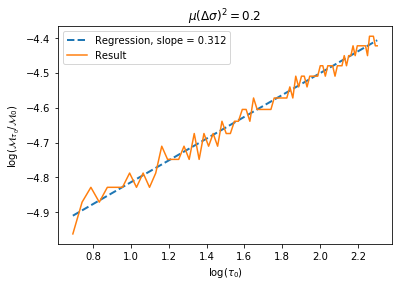

In [28]:
x = np.log(tau0s*Time)
a,b,c,d,e = linregress(x,np.log(falsepars[:,1]/pars[1]-1.))
plt.plot(x,a*x+b,'--',lw=2.,label='Regression, slope = '+str(round(a,3)))
plt.title(r'$\mu(\Delta\sigma)^2=$'+str(pars[2]))
plt.plot(x,np.log(falsepars[:,1]/pars[1]-1.),label='Result')
plt.ylabel(r'$\log(\mathcal{M}_{\tau_0}/\mathcal{M}_0)$')
plt.xlabel(r'$\log(\tau_0)$')
plt.legend(loc='best')
plt.savefig('chirpgrowthtau0.png',bbox_inches='tight')